In [1]:
import torch
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
# from dataset import PigPenDataset

In [ ]:
# dataset = PigPenDataset(data_dir_path="../data/annotated", images=True, annotations=True)

In [3]:
import numpy as np
from hog.models.mappings import get_actions_mapper, get_objects_mapper

data_dir_path = "data/annotated"
data_split = "test"

objects = np.load("data/annotated/objects_test.npy")
actions = np.load("data/annotated/actions_test.npy")
seen_matrix = np.load("data/annotated/seen_test.npy")

precondition_text = np.load(
    f"{data_dir_path}/precondition_language_{data_split}.npy",
    allow_pickle=True,
)
action_text = np.load(
    f"{data_dir_path}/action_language_{data_split}.npy", allow_pickle=True
)
postcondition_text = np.load(
    f"{data_dir_path}/postcondition_language_{data_split}.npy",
    allow_pickle=True,
)

action_idx_to_name = get_actions_mapper("data")
object_attributes_idx_to_mapper = get_objects_mapper("data")

image_indices_file = f"{data_dir_path}/img_indices_{data_split}.npy"
image_indices = np.load(image_indices_file)

In [4]:
objects.shape
actions.shape
seen_matrix.shape

(398,)

In [5]:
print(precondition_text[9])
print(action_text[9])
print(postcondition_text[9])

['The robot is standing next to an open cabinet.'
 'There is an empty open cabinet.'
 'The cabinet is open and taking up more space.']
['The robot closes the cabinet.' 'The robot closes the cabinet'
 'The robot closes the cabinet.']
['The cabinet is now closed, taking up less space.'
 'The cabinet is now closed and takes up less space'
 'The cabinet is now closed and taking up less space.']


In [6]:
for o in objects[9][:,0][[1,2]]:
    print(object_attributes_idx_to_mapper[0][o])

Cabinet
Sink


In [7]:
image_indices[9]

763

In [8]:
import numpy as np
from PIL import Image

import matplotlib.colors as mcolors
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_cmap(cm="jet", N=256):
    colors = getattr(plt.cm, cm)(np.linspace(0,1,N))
    transparent_hot_colors = []
    for c, t in zip(colors, np.linspace(0,1,N)):
        transparent_hot_colors.append(c)
        transparent_hot_colors[-1][-1] = t
    return mcolors.LinearSegmentedColormap.from_list('hot', transparent_hot_colors, N=N)

def calculate_attention_weights_per_pixel(bboxes, scores):
    attention_weights = torch.zeros(384, 640, 1)
    for box, score in zip(bboxes, scores):
        x_min, y_min, x_max, y_max = box
        attention_weights[y_min:y_max, x_min:x_max] += score
    return attention_weights


def imshow_with_attention_overlay(ax, image, bboxes, scores):
    attention_weights = calculate_attention_weights_per_pixel(bboxes, scores)
    ax.imshow(image)
    ax.imshow(attention_weights, cmap=get_cmap())
    
    
def turn_off_axis(ax):
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
def plot_effect_grid(images, bboxes, scores, objects):
    dpi = 100
    sizes = np.shape(images[0])
    fig, axs  = plt.subplots(2,2, figsize=((sizes[1]/dpi)*2, (sizes[0]/dpi)*2), dpi=dpi)
    canvas = FigureCanvas(fig)
    caption_dict = {0: "Before", 1: "After"}
    for i in range(2):
        for o in range(2):
            if i == 0:
                axs[i][o].set_title(f"{objects[0]}")
            if o == 0:
                axs[i][o].set_ylabel(caption_dict[i])

            turn_off_axis(axs[i][o])
            imshow_with_attention_overlay(axs[i][o], images[i], bboxes[i], scores[i][o])

    plt.subplots_adjust(wspace=0, hspace=0)

    canvas.draw()

    image_from_plot = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(canvas.get_width_height()[::-1] + (3,))
    
    return image_from_plot



In [ ]:
images, bboxes = dataset.get_images_and_bounding_boxes(0)
scores = torch.randn(2, 2, 100).softmax(-1)
arr = plot_effect_grid(images, bboxes, scores, ["a", "B"])
# scores.shape


In [ ]:
im = Image.fromarray(arr)
im

In [ ]:
import pandas as pd

In [15]:
import pandas as pd 
import wandb

api = wandb.Api()
entity, project = "itl", "hog"  # set to your entity and project 
runs = api.runs(entity + "/" + project) 

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
         if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

# runs_df.to_csv("project.csv")
runs_df = pd.concat([runs_df, runs_df.summary.apply(pd.Series)], axis=1)
runs_df = runs_df[runs_df.name.str.contains("_nlu")]
runs_df["run_group"] = runs_df.name.apply(lambda x: x.split("_l3")[0])
# runs_df = runs_df.dropna()

In [17]:
# runs_df

In [18]:
runs_df["run_group"].unique()

array(['base+images+full_h64', 'base+symbolic+full_h64',
       'base+images+text-labels+full_h64', 'base+images_h64',
       'base+images+label-names_h64', 'base_h64', 'base+symbolic_h64',
       'base+images+symbolic_h64', 'images_embed_names_h64',
       'piglet_no_symbolic_h64', 'piglet_h64', 'images_fuse_h64'],
      dtype=object)

In [20]:
def get_run_group_name(run_group):
    if "base+images+symbolic_" in run_group:
        return "base+images+symbolic"
    elif "images_embed" in run_group:
        return run_group
    elif "base+images+label-names_" in run_group:
        return "base+images+text-labels"
    elif "images_fuse" in run_group:
        return run_group
    elif "base+images_" in run_group:
        return "base+images"
    elif "piglet_no_symbolic" in run_group or "base_" in run_group:
        return "base"
    elif "piglet" in run_group or "base+symbolic_" in run_group:
        return "base+symbolic"
    else:
        return ""
    raise ValueError(f"Unknown run group: {run_group}")

runs_df["full"] = runs_df["run_group"].apply(lambda x: "full" in x)
runs_df["run_group"] = runs_df["run_group"].apply(get_run_group_name)


In [22]:
runs_df = runs_df[runs_df["run_group"] != ""].copy().reset_index(drop=True)

In [23]:
order = [
 'base',
 'base+images',
 'base+images+text-labels',
 'base+symbolic',
 'base+images+symbolic',
 ]

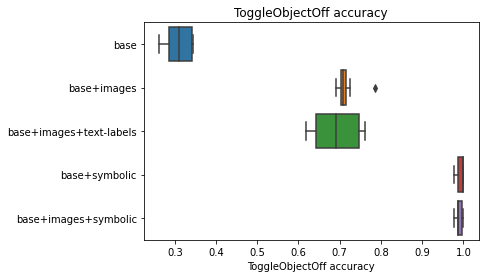

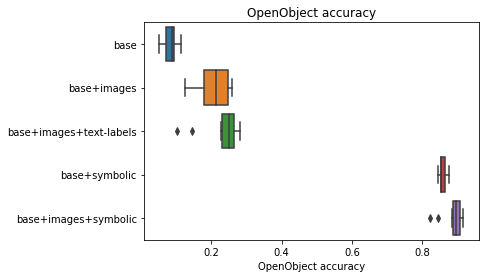

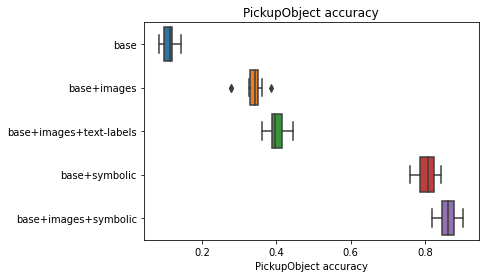

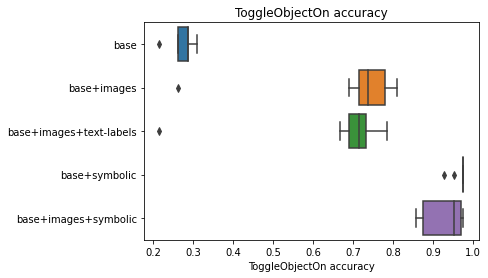

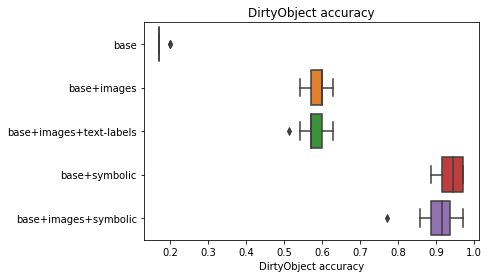

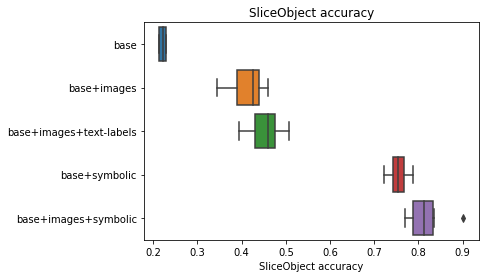

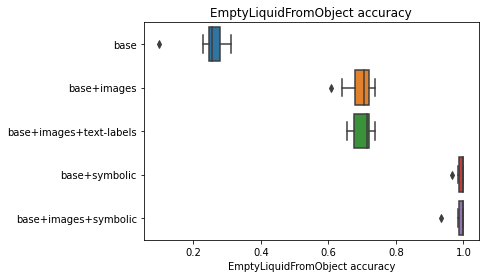

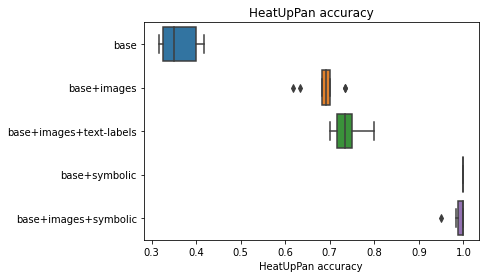

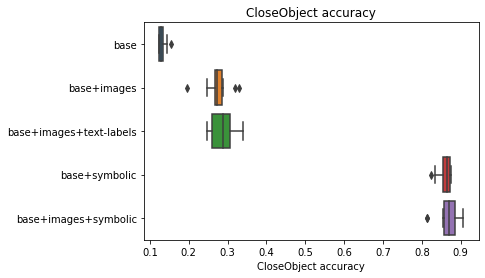

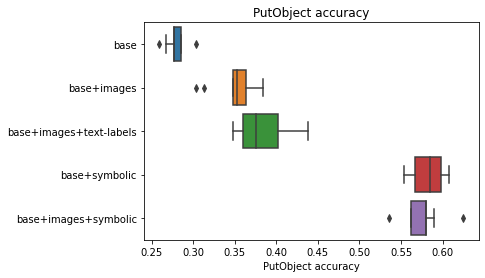

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

for n in runs_df.columns.values:
  if "test" in n and "Action Accuracy" in n:
    sns.boxplot(data=runs_df, 
                y="run_group", x=n, 
                order=order)
    t = n.split("_")[-2]+" "+n.split("_")[-1]
    plt.title(t)
    plt.xlabel(t)
    plt.ylabel("")
    plt.show()

In [177]:
# runs_df.columns.values

In [6]:
runs_df.run_group.value_counts()

base+images                10
base+images+text-labels    10
base                       10
base+symbolic              10
base+images+symbolic       10
images_embed_names_h64      5
images_fuse_h64             5
Name: run_group, dtype: int64

In [7]:
from scipy import stats

cols = ["base+images",  "base+images+text-labels"]
vals = ["Accuracy/test_unseen_average_accuracy", "Accuracy/test_average_accuracy", 'Action Accuracy/test_PickupObject_accuracy']
for v in vals:
  a = runs_df[runs_df.run_group == cols[0]][v].values
  b = runs_df[runs_df.run_group == cols[1]][v].values
  print(v)
  print(f"{cols[0]}: {a.mean():.4f}+-{a.std():.4f}\t{cols[1]}: {b.mean():.4f}+-{b.std():.4f}")
  print(f"pvalue={stats.ttest_ind(a, b).pvalue}")

Accuracy/test_unseen_average_accuracy
base+images: 0.0753+-0.0247	base+images+text-labels: 0.0890+-0.0308
pvalue=0.3115146613296908
Accuracy/test_average_accuracy
base+images: 0.4547+-0.0143	base+images+text-labels: 0.4755+-0.0199
pvalue=0.02015030932177231
Action Accuracy/test_PickupObject_accuracy
base+images: 0.3349+-0.0327	base+images+text-labels: 0.4012+-0.0247
pvalue=0.00012834994535545151


In [24]:
from scipy import stats

cols = ["base+images",  "base+images+text-labels"]
vals = ["Accuracy/test_unseen_average_accuracy", "Accuracy/test_average_accuracy", 'Action Accuracy/test_SliceObject_accuracy']
for v in vals:
  a = runs_df[runs_df.run_group == cols[0]][v].values
  b = runs_df[runs_df.run_group == cols[1]][v].values
  print(v)
  print(f"{cols[0]}: {a.mean():.4f}+-{a.std():.4f}\t{cols[1]}: {b.mean():.4f}+-{b.std():.4f}")
  print(f"pvalue={stats.ttest_ind(a, b).pvalue}")

# atts_accs = sorted([r for r in list(runs_df.columns) if "Attribute Accuracy/test_distance" in r])
# a = runs_df[runs_df.run_group == cols[0]][atts_accs].values.flatten()
# b = runs_df[runs_df.run_group == cols[1]][atts_accs].values.flatten()
# print("Attribute Accuracy")
# print(f"{cols[0]}: {a.mean():.4f}+-{a.std():.4f}\t{cols[1]}: {b.mean():.4f}+-{b.std():.4f}")
# print(f"pvalue={stats.ttest_ind(a, b).pvalue}")
# act_accs = sorted([r for r in list(runs_df.columns) if "Action Accuracy/test" in r])
# a = runs_df[runs_df.run_group == cols[0]][act_accs].values.flatten()
# b = runs_df[runs_df.run_group == cols[1]][act_accs].values.flatten()
# print("Action Accuracy")
# print(f"{cols[0]}: {a.mean():.4f}+-{a.std():.4f}\t{cols[1]}: {b.mean():.4f}+-{b.std():.4f}")
# print(f"pvalue={stats.ttest_ind(a, b).pvalue}") 

Accuracy/test_unseen_average_accuracy
base+images: 0.0753+-0.0247	base+images+text-labels: 0.0890+-0.0308
pvalue=0.3115146613296908
Accuracy/test_average_accuracy
base+images: 0.4547+-0.0143	base+images+text-labels: 0.4755+-0.0199
pvalue=0.02015030932177231
Action Accuracy/test_SliceObject_accuracy
base+images: 0.4164+-0.0361	base+images+text-labels: 0.4557+-0.0365
pvalue=0.033631160886288175


In [25]:
cols = ["base",  "base+images+text-labels"]
vals = ["Accuracy/test_unseen_average_accuracy", "Accuracy/test_average_accuracy", 'Action Accuracy/test_SliceObject_accuracy']
for v in vals:
  a = runs_df[runs_df.run_group == cols[0]][v].values
  b = runs_df[runs_df.run_group == cols[1]][v].values
  print(v)
  print(f"{cols[0]}: {a.mean():.4f}+-{a.std():.4f}\t{cols[1]}: {b.mean():.4f}+-{b.std():.4f}")
  print(f"pvalue={stats.ttest_ind(a, b).pvalue}")

Accuracy/test_unseen_average_accuracy
base: 0.0534+-0.0263	base+images+text-labels: 0.0890+-0.0308
pvalue=0.01669326647746051
Accuracy/test_average_accuracy
base: 0.2123+-0.0069	base+images+text-labels: 0.4755+-0.0199
pvalue=1.5164232928297336e-18
Action Accuracy/test_SliceObject_accuracy
base: 0.2213+-0.0082	base+images+text-labels: 0.4557+-0.0365
pvalue=2.808446783591938e-13


In [9]:
cols = ["base+symbolic",  "base+images+symbolic"]
vals = ["Accuracy/test_unseen_average_accuracy", "Accuracy/test_average_accuracy", 'Action Accuracy/test_PickupObject_accuracy']
for v in vals:
  a = runs_df[runs_df.run_group == cols[0]][v].values
  b = runs_df[runs_df.run_group == cols[1]][v].values
  print(v)
  print(f"{cols[0]}: {a.mean():.4f}+-{a.std():.4f}\t{cols[1]}: {b.mean():.4f}+-{b.std():.4f}")
  print(f"pvalue={stats.ttest_ind(a, b).pvalue}")

Accuracy/test_unseen_average_accuracy
base+symbolic: 0.3904+-0.0320	base+images+symbolic: 0.3589+-0.0329
pvalue=0.054068795136908994
Accuracy/test_average_accuracy
base+symbolic: 0.8503+-0.0042	base+images+symbolic: 0.8601+-0.0084
pvalue=0.006376151293233091
Action Accuracy/test_PickupObject_accuracy
base+symbolic: 0.8048+-0.0274	base+images+symbolic: 0.8614+-0.0242
pvalue=0.000200838771823258


# Tables 

## Overall Table

In [37]:
run_groups = ["base", "base+symbolic", "base+images",  "base+images+symbolic", "base+images+text-labels"]

overall_accs = ["Accuracy/test_average_accuracy", 
                "Accuracy/test_unseen_average_accuracy"]

for run_group in run_groups:
  row = "\\texttt{"+ run_group +"}"
  for acc in overall_accs:
    avg_accuracy = "{:.2f}".format(runs_df[runs_df.run_group == run_group][acc].mean()*100)
    std_accuracy = "{:.2f}".format(runs_df[runs_df.run_group == run_group][acc].std()*100)
    row += f"& ${avg_accuracy}\pm{std_accuracy}$"
  row += "\\\\"
  print(row)

\texttt{base}& $21.23\pm0.72$& $5.34\pm2.77$\\
\texttt{base+symbolic}& $85.03\pm0.45$& $39.04\pm3.37$\\
\texttt{base+images}& $45.47\pm1.50$& $7.53\pm2.60$\\
\texttt{base+images+symbolic}& $86.01\pm0.89$& $35.89\pm3.47$\\
\texttt{base+images+text-labels}& $47.55\pm2.10$& $8.90\pm3.24$\\


In [12]:
run_groups = ["base", "base+symbolic", "base+images",  "base+images+symbolic", "base+images+text-labels"]

overall_accs = ["Accuracy/val_average_accuracy", 
                "Accuracy/test_average_accuracy", 
                "Accuracy/test_unseen_average_accuracy"]

for run_group in run_groups:
  row = "\\texttt{"+ run_group +"}"
  for acc in overall_accs:
    avg_accuracy = "{:.2f}".format(runs_df[runs_df.run_group == run_group][acc].mean()*100)
    std_accuracy = "{:.2f}".format(runs_df[runs_df.run_group == run_group][acc].std()*100)
    row += f"& ${avg_accuracy}\pm{std_accuracy}$"
  row += "\\\\"
  print(row)

\texttt{base}& $23.85\pm0.95$& $21.23\pm0.72$& $5.34\pm2.77$\\
\texttt{base+symbolic}& $88.08\pm0.50$& $85.03\pm0.45$& $39.04\pm3.37$\\
\texttt{base+images}& $50.73\pm2.97$& $45.47\pm1.50$& $7.53\pm2.60$\\
\texttt{base+images+symbolic}& $89.49\pm0.82$& $86.01\pm0.89$& $35.89\pm3.47$\\
\texttt{base+images+text-labels}& $53.33\pm3.15$& $47.55\pm2.10$& $8.90\pm3.24$\\


## Joint in-text table

In [38]:
attribute_accs = ['Attribute Accuracy/test_size_accuracy', 
                  'Attribute Accuracy/test_distance_accuracy',
                  'Attribute Accuracy/test_ObjectTemperature_accuracy']

action_accs =  ['Action Accuracy/test_OpenObject_accuracy',
                'Action Accuracy/test_PickupObject_accuracy',
                'Action Accuracy/test_ToggleObjectOn_accuracy',
                'Action Accuracy/test_SliceObject_accuracy']
              # 'Attribute Accuracy/test_mass_accuracy', 
              # 'Attribute Accuracy/test_ObjectTemperature_accuracy',
              # 'Attribute Accuracy/test_breakable_accuracy',
              # 'Attribute Accuracy/test_isBroken_accuracy']
              
for run_group in run_groups:
  row = "\\texttt{"+ run_group +"}"
  for acc in action_accs:
    avg_accuracy = "{:.2f}".format(runs_df[runs_df.run_group == run_group][acc].mean()*100)
    # std_accuracy = "{:.2f}".format(runs_df[runs_df.run_group == run_group][acc].std()*100)
    # row += f"& ${avg_accuracy}\pm{std_accuracy}$"
    row += f"& ${avg_accuracy}$"
  row += "&"
  for acc in attribute_accs:
    avg_accuracy = "{:.2f}".format(runs_df[runs_df.run_group == run_group][acc].mean()*100)
    row += f"& ${avg_accuracy}$"
  row += "\\\\"
  print(row)
  


\texttt{base}& $8.33$& $10.96$& $27.38$& $22.13$&& $73.78$& $51.01$& $95.91$\\
\texttt{base+symbolic}& $85.73$& $80.48$& $96.90$& $75.41$&& $94.98$& $95.13$& $99.85$\\
\texttt{base+images}& $20.83$& $33.49$& $70.24$& $41.64$&& $87.03$& $76.62$& $96.10$\\
\texttt{base+images+symbolic}& $88.75$& $86.14$& $92.86$& $81.31$&& $96.35$& $96.13$& $99.59$\\
\texttt{base+images+text-labels}& $22.92$& $40.12$& $67.14$& $45.57$&& $87.89$& $78.06$& $96.72$\\


## Appendix Action Accs

In [40]:
# base_image_symbols

action_accs = sorted([r for r in list(runs_df.columns) if "Action Accuracy/test" in r])
# # action_accs =  ['Action Accuracy/test_OpenObject_accuracy',
#                 'Action Accuracy/test_PickupObject_accuracy',
#                 'Action Accuracy/test_HeatUpPan_accuracy',
#                 'Action Accuracy/test_SliceObject_accuracy']

# print(action_accs)

row = ""
for a in action_accs[:5]:
  row += "&" + a.split("_")[-2].replace("Object", "").replace("From", "")
row += "\\\\"
print(row)
for run_group in run_groups:
  row = "\\texttt{"+ run_group +"}"
  for acc in action_accs[:5]:
    avg_accuracy = "{:.2f}".format(runs_df[runs_df.run_group == run_group][acc].mean()*100)
    std_accuracy = "{:.2f}".format(runs_df[runs_df.run_group == run_group][acc].std()*100)
    row += f"& ${avg_accuracy}\pm{std_accuracy}$"
  row += "\\\\"
  print(row)

row = ""
for a in action_accs[5:]:
  row += "&" + a.split("_")[-2].replace("Object", "").replace("From", "")
row += "\\\\"
print(row)
for run_group in run_groups:
  row = "\\texttt{"+ run_group +"}"
  for acc in action_accs[5:]:
    avg_accuracy = "{:.2f}".format(runs_df[runs_df.run_group == run_group][acc].mean()*100)
    std_accuracy = "{:.2f}".format(runs_df[runs_df.run_group == run_group][acc].std()*100)
    row += f"& ${avg_accuracy}\pm{std_accuracy}$"
  row += "\\\\"
  print(row)




&Close&Dirty&EmptyLiquid&HeatUpPan&Open\\
\texttt{base}& $13.20\pm1.06$& $17.71\pm1.20$& $24.75\pm5.75$& $36.33\pm4.14$& $8.33\pm1.84$\\
\texttt{base+symbolic}& $85.98\pm1.77$& $94.00\pm3.42$& $99.34\pm1.15$& $100.00\pm0.00$& $85.73\pm0.99$\\
\texttt{base+images}& $27.42\pm3.71$& $58.57\pm2.78$& $69.34\pm4.17$& $68.67\pm3.75$& $20.83\pm4.63$\\
\texttt{base+images+symbolic}& $86.80\pm3.29$& $90.29\pm5.90$& $99.02\pm2.07$& $99.17\pm1.62$& $88.75\pm3.02$\\
\texttt{base+images+text-labels}& $28.87\pm3.19$& $57.71\pm3.24$& $70.16\pm3.17$& $74.00\pm3.16$& $22.92\pm5.79$\\
&Pickup&Put&Slice&ToggleOff&ToggleOn\\
\texttt{base}& $10.96\pm1.92$& $27.95\pm1.19$& $22.13\pm0.86$& $30.83\pm3.39$& $27.38\pm2.57$\\
\texttt{base+symbolic}& $80.48\pm2.88$& $58.39\pm1.94$& $75.41\pm1.89$& $99.40\pm0.84$& $96.90\pm1.61$\\
\texttt{base+images}& $33.49\pm3.45$& $34.91\pm2.43$& $41.64\pm3.80$& $71.43\pm2.75$& $70.24\pm16.00$\\
\texttt{base+images+symbolic}& $86.14\pm2.56$& $57.59\pm2.31$& $81.31\pm3.96$& $99.

In [41]:
atts_accs = sorted([r for r in list(runs_df.columns) if "Attribute Accuracy/test" in r])
# # action_accs =  ['Action Accuracy/test_OpenObject_accuracy',
#                 'Action Accuracy/test_PickupObject_accuracy',
#                 'Action Accuracy/test_HeatUpPan_accuracy',
#                 'Action Accuracy/test_SliceObject_accuracy']

# print(action_accs)

for i in range(0, len(atts_accs), 10):
  row = ""
  for a in atts_accs[i:i+10]:
    row += "&\\texttt{" + a.split("_")[-2].replace("Object", "").replace("From", "") + "}"
  row += "\\\\"
  print(row)
  for run_group in run_groups:
    row = "\\texttt{"+ run_group +"}"
    for acc in atts_accs[i:i+10]:
      avg_accuracy = "{:.2f}".format(runs_df[runs_df.run_group == run_group][acc].mean()*100)
      std_accuracy = "{:.2f}".format(runs_df[runs_df.run_group == run_group][acc].std()*100)
      row += f"& ${avg_accuracy}\pm{std_accuracy}$"
    row += "\\\\"
    print(row)

# row = ""
# for a in action_accs[5:]:
#   row += "&" + a.split("_")[-2].replace("Object", "").replace("From", "")
# row += "\\\\"
# print(row)
# for run_group in run_groups:
#   row = "\\texttt{"+ run_group +"}"
#   for acc in action_accs[5:]:
#     avg_accuracy = "{:.2f}".format(runs_df[runs_df.run_group == run_group][acc].mean()*100)
#     std_accuracy = "{:.2f}".format(runs_df[runs_df.run_group == run_group][acc].std()*100)
#     row += f"& ${avg_accuracy}\pm{std_accuracy}$"
#   row += "\\\\"
#   print(row)

&\texttt{Name}&\texttt{Temperature}&\texttt{attribute}&\texttt{breakable}&\texttt{cookable}&\texttt{dirtyable}&\texttt{distance}&\texttt{isBroken}&\texttt{isCooked}&\texttt{isDirty}\\
\texttt{base}& $99.66\pm0.07$& $95.91\pm0.41$& $96.12\pm0.07$& $91.46\pm0.36$& $99.95\pm0.07$& $99.95\pm0.10$& $51.01\pm0.93$& $99.86\pm0.00$& $98.60\pm0.06$& $97.93\pm0.19$\\
\texttt{base+symbolic}& $99.64\pm0.12$& $99.85\pm0.04$& $99.48\pm0.03$& $99.84\pm0.09$& $100.00\pm0.00$& $100.00\pm0.00$& $95.13\pm0.35$& $100.00\pm0.00$& $99.85\pm0.04$& $99.71\pm0.14$\\
\texttt{base+images}& $96.94\pm0.48$& $96.10\pm0.87$& $97.20\pm0.15$& $92.59\pm0.85$& $99.90\pm0.07$& $99.71\pm0.19$& $76.62\pm0.89$& $99.85\pm0.04$& $98.56\pm0.23$& $98.00\pm0.34$\\
\texttt{base+images+symbolic}& $99.62\pm0.09$& $99.59\pm0.27$& $99.48\pm0.04$& $99.78\pm0.10$& $100.00\pm0.00$& $99.97\pm0.09$& $96.13\pm0.40$& $100.00\pm0.00$& $99.85\pm0.04$& $99.52\pm0.32$\\
\texttt{base+images+text-labels}& $98.51\pm0.28$& $96.72\pm0.45$& $97.50\pm

In [128]:
sorted([r for r in list(runs_df.columns) if "Action Accuracy/test" in r])

['Action Accuracy/test_CloseObject_accuracy',
 'Action Accuracy/test_DirtyObject_accuracy',
 'Action Accuracy/test_EmptyLiquidFromObject_accuracy',
 'Action Accuracy/test_HeatUpPan_accuracy',
 'Action Accuracy/test_OpenObject_accuracy',
 'Action Accuracy/test_PickupObject_accuracy',
 'Action Accuracy/test_PutObject_accuracy',
 'Action Accuracy/test_SliceObject_accuracy',
 'Action Accuracy/test_ToggleObjectOff_accuracy',
 'Action Accuracy/test_ToggleObjectOn_accuracy']

In [ ]:
&Close&Dirty&EmptyLiquid&HeatUpPan&Open&Pickup&Put&Slice&ToggleOff&ToggleOn\\

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}